# Build disadvantaged community suitablity layers for GRIDCERF


The following code was used to build the disadvantaged community suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Climate and Economic Justice Screening Tool (CEJST)
- **Description from Source**: The tool highlights disadvantaged census tracts across all 50 states, the District of Columbia, and the U.S. territories. Communities are considered disadvantaged: If they are in census tracts that meet the thresholds for at least one of the tool’s categories of burden, or If they are on land within the boundaries of Federally Recognized Tribes
- **Source URL**:  https://static-data-screeningtool.geoplatform.gov/data-versions/1.0/data/score/downloadable/1.0-shapefile-codebook.zip
- **Date Accessed**:  9/26/23
- **Citation**
> White House Council on Environmental Quality, 2022. Climate and Economic Justice Screening Tool (CEJST). https://static-data-screeningtool.geoplatform.gov/data-versions/1.0/data/score/downloadable/1.0-shapefile-codebook.zip.
- **Application**:
CEJST provides data on a census tract level of vulnerable communities to align with the Justice40 initiative. Different vulnerabilities for climate, energy, water, health, housing, pollution, transportation, and workforce are included. For more information visit: https://screeningtool.geoplatform.gov/en/methodology . Inclusive and exclusive GRIDCERF suitability layers are created for each of the vulnerability types.

### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [3]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'cejst_disadvantaged_communities' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
cejst_shpfile = os.path.join(source_dir, '1.0-shapefile-codebook', 'usa', "usa.shp")

# output rasters
output_climate_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_climate_dacs.tif")
output_climate_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_climate_dacs.tif")

output_energy_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_energy_dacs.tif")
output_energy_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_energy_dacs.tif")

output_health_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_health_dacs.tif")
output_health_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_health_dacs.tif")

output_housing_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_housing_dacs.tif")
output_housing_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_housing_dacs.tif")

output_pollution_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_pollution_dacs.tif")
output_pollution_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_pollution_dacs.tif")

output_transportation_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_transportation_dacs.tif")
output_transportation_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_transportation_dacs.tif")

output_water_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_water_dacs.tif")
output_water_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_water_dacs.tif")

output_workforce_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_workforce_dacs.tif")
output_workforce_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_workforce_dacs.tif")

output_all_exc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_exclude_all_dacs.tif")
output_all_inc_file = os.path.join(technology_specific_dir, "gridcerf_usceq_cejst_include_all_dacs.tif")


# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'

dac_dict = {
    'climate' : 'N_CLT',
    'energy' :'N_ENY',
    'health' :'N_HLTH',
    'housing' :'N_HSG',
    'pollution' :'N_PLN',
    'transportation' :'N_TRN',
    'water' :'N_WTR',
    'workforce' :'N_WKFC',
    'all': 'SN_C'}

## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [10]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster, include):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)

            # invert suitability for inclusion layer
            if include:
                burned = np.where(burned==1, 0, 1).astype(np.float64)
            else:
                pass
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [5]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

In [6]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(cejst_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

#### 4.2.1. Climate DAC


<Axes: >

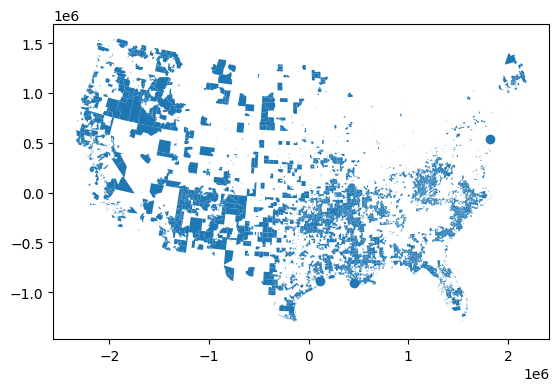

In [8]:
# retrieve data code from dictionary
dac_key = dac_dict['climate']

# separate out specific DAC category
climate_gdf = gdf[gdf[dac_key] == 1]

climate_gdf.plot()

In [12]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=climate_gdf, 
                 value_field="value",
                 output_raster=output_climate_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=climate_gdf, 
                 value_field="value",
                 output_raster=output_climate_inc_file, 
                include=True)

#### 4.2.2. Energy DAC


<Axes: >

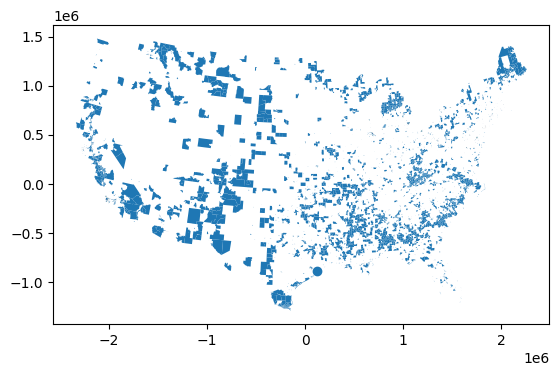

In [13]:
# retrieve data code from dictionary
dac_key = dac_dict['energy']

# separate out specific DAC category
energy_gdf = gdf[gdf[dac_key] == 1]

energy_gdf.plot()

In [15]:
g = energy_gdf

# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=g, 
                 value_field="value",
                 output_raster=output_energy_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=g, 
                 value_field="value",
                 output_raster=output_energy_inc_file, 
                include=True)

#### 4.2.3. Health DAC


<Axes: >

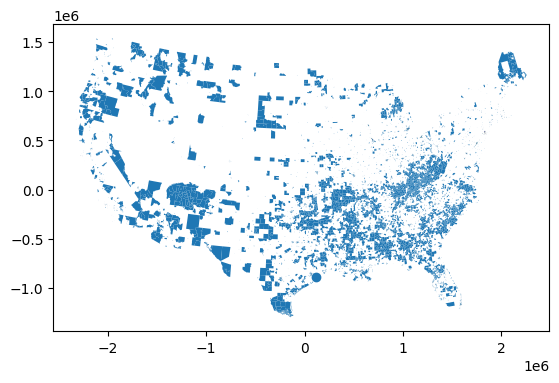

In [16]:
# retrieve data code from dictionary
dac_key = dac_dict['health']

# separate out specific DAC category
health_gdf = gdf[gdf[dac_key] == 1]

health_gdf.plot()

In [17]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=health_gdf, 
                 value_field="value",
                 output_raster=output_health_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=health_gdf, 
                 value_field="value",
                 output_raster=output_health_inc_file, 
                include=True)

#### 4.2.4. Housing DAC


<Axes: >

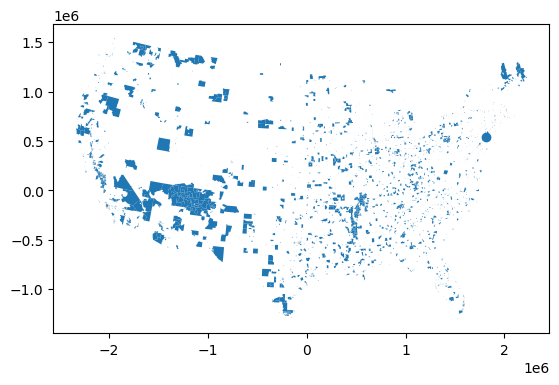

In [18]:
# retrieve data code from dictionary
dac_key = dac_dict['housing']

# separate out specific DAC category
housing_gdf = gdf[gdf[dac_key] == 1]

housing_gdf.plot()

In [19]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=housing_gdf, 
                 value_field="value",
                 output_raster=output_housing_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=housing_gdf, 
                 value_field="value",
                 output_raster=output_housing_inc_file, 
                include=True)

#### 4.2.5. Pollution DAC


<Axes: >

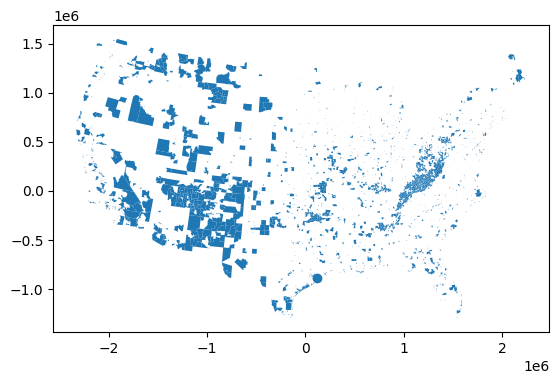

In [20]:
# retrieve data code from dictionary
dac_key = dac_dict['pollution']

# separate out specific DAC category
pollution_gdf = gdf[gdf[dac_key] == 1]

pollution_gdf.plot()

In [21]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=pollution_gdf, 
                 value_field="value",
                 output_raster=output_pollution_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=pollution_gdf, 
                 value_field="value",
                 output_raster=output_pollution_inc_file, 
                include=True)

#### 4.2.6. Transportation DAC


<Axes: >

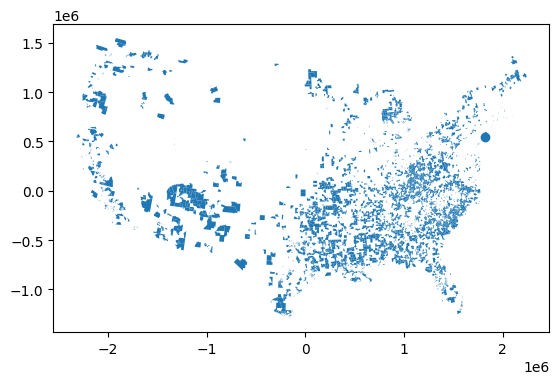

In [22]:
# retrieve data code from dictionary
dac_key = dac_dict['transportation']

# separate out specific DAC category
transportation_gdf = gdf[gdf[dac_key] == 1]

transportation_gdf.plot()

In [23]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=transportation_gdf, 
                 value_field="value",
                 output_raster=output_transportation_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=transportation_gdf, 
                 value_field="value",
                 output_raster=output_transportation_inc_file, 
                include=True)

#### 4.2.7. Water DAC


<Axes: >

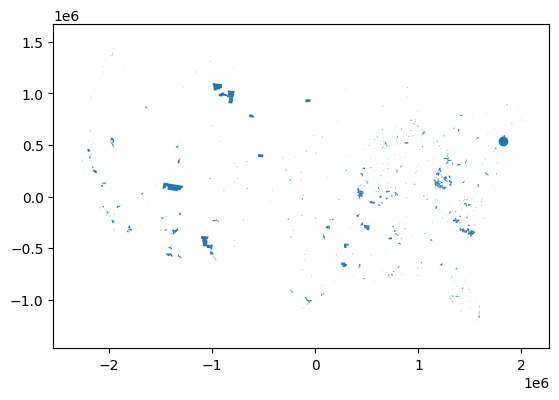

In [24]:
# retrieve data code from dictionary
dac_key = dac_dict['water']

# separate out specific DAC category
water_gdf = gdf[gdf[dac_key] == 1]

water_gdf.plot()

In [25]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=water_gdf, 
                 value_field="value",
                 output_raster=output_water_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=water_gdf, 
                 value_field="value",
                 output_raster=output_water_inc_file, 
                include=True)

#### 4.2.8. Workforce DAC


<Axes: >

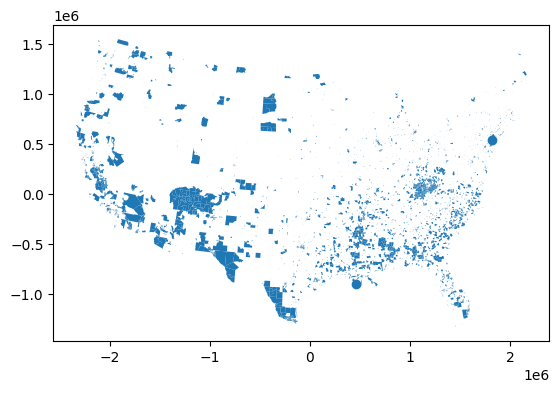

In [26]:
# retrieve data code from dictionary
dac_key = dac_dict['workforce']

# separate out specific DAC category
workforce_gdf = gdf[gdf[dac_key] == 1]

workforce_gdf.plot()

In [27]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=workforce_gdf, 
                 value_field="value",
                 output_raster=output_workforce_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=workforce_gdf, 
                 value_field="value",
                 output_raster=output_workforce_inc_file, 
                include=True)

#### 4.2.9. All DAC

<Axes: >

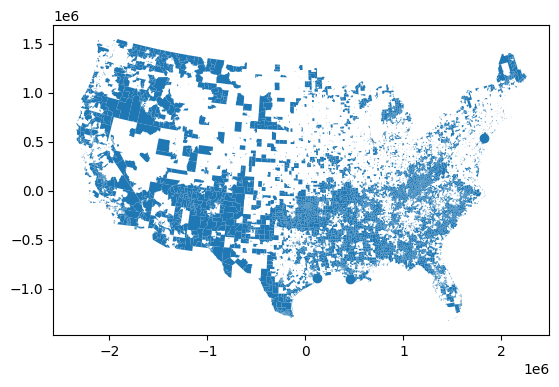

In [28]:
# retrieve data code from dictionary
dac_key = dac_dict['all']

# separate out specific DAC category
all_gdf = gdf[gdf[dac_key] == 1]

all_gdf.plot()

In [29]:
# generate raster for excluded area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=all_gdf, 
                 value_field="value",
                 output_raster=output_all_exc_file, 
                include=False)

# generate raster for included area
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=all_gdf, 
                 value_field="value",
                 output_raster=output_all_inc_file, 
                include=True)